# Jupyter notebook - Neural Network for digit recognition

We do an exercise to recognize the digits using keras.


In [ ]:
import os
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Conv2D
from keras import optimizers
import logging
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from keras.datasets import mnist

# Digit Recognition

In [2]:
# show data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Basic NN

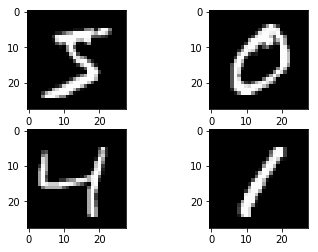

In [3]:
# plot 4 images as gray scale
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [4]:
# 
seed = 7
np.random.seed(seed)
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][pixels][width][height]

Looking at the traning set we have a 3 dimensiional array: istance, image width and image height. We can reshape using reshape function.

In [5]:
print('Shape X train: ', X_train.shape)
print('Shape y train: ', y_train.shape)

Shape X train:  (60000, 28, 28)
Shape y train:  (60000,)


In [6]:
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0],num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0],num_pixels).astype('float32')

print('Shape X train: ', X_train.shape)


Shape X train:  (60000, 784)


The pixel values are gray scale between 0 and 255. It is almost always a good idea to perform some scaling of input values when using neural network models.

In [9]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

In [10]:
# our output is categorical from 0 to 9, we have 10 elements as 10 are the possible digits
# we need to create dummies, and we can use OneHotEncoder or pd.get_dummies

# in this case we don't need to drop the first because we are not regressing on them, so we will not have any collinear
# issue since we are transforming in dummy our outcome.
# Basically each outcome is a vector of zeros where there is a 1, and the one is placed in the position of the digit
y_train = np.asarray(pd.get_dummies(y_train))
y_test = np.asarray(pd.get_dummies(y_test))
num_classes = y_test.shape[1]

# Keras has its own "dummies" converter
# from keras.utils import to_categorical
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

Exception: Data must be 1-dimensional

The model is a simple neural network with one hidden layer with the same number of neurons as there are inputs (784). The activation function is a rectifier.

$$f(x) = max(0,x) $$

where x is the input of the neuron.

We use a 'softmax' activation for the output layer. Softmax is often used in neural networks, to map the non-normalized output of a network to a probability distribution over predicted output classes. Since our output needs to be between 0 and 1 this function works well.
It formula is:

$$ f(x) = \frac{\exp(z_i)}{\sum_{j=1}^{K} exp(z_j)}$$

where K is my number of output (10).

To evaluate the model we use the Logarithmic loss and the ADAM gradient descent. (There are different optimizers).

In [12]:
# we define a function called baseline model with 2 layers.
# Both the layers are Dense because each input loads on each first layer nodes and each first layer nodes loads on the
# second layer nodes.

# kernel_intializer is to initialize the weights, and they are initialized as normal.
# there are other way: ones, constant, uniform...
# activation is the activation function in the nodes:
# can be sigmoid, relu, softmax, tanh.
# To evaluate the performances we use cross_entropy.
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


One **epoch** consists of one full training cycle on the training set.  Once every sample in the set is seen, you start again - marking the beginning of the 2nd epoch.


The **batch size** defines the number of samples that will be propagated through the network.

For instance, let's say you have 1050 training samples and you want to set up a batch_size equal to 100. The algorithm takes the first 100 samples (from 1st to 100th) from the training dataset and trains the network. Next, it takes the second 100 samples (from 101st to 200th) and trains the network again. We can keep doing this procedure until we have propagated all samples through of the network. 

In our case we have epoch =10 and batch_size = 200. So we go trough the entire traning sample 10 times, using small batched of 200 elements. The one above that takes the elements sequentially it is just an example.

In [13]:
# build the model
model = baseline_model()

# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))


W0625 10:37:34.716325 4411364800 deprecation_wrapper.py:119] From /Users/paoloandreini/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0625 10:37:34.840897 4411364800 deprecation_wrapper.py:119] From /Users/paoloandreini/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0625 10:37:34.930409 4411364800 deprecation_wrapper.py:119] From /Users/paoloandreini/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0625 10:37:35.005800 4411364800 deprecation_wrapper.py:119] From /Users/paoloandreini/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 3s - loss: 0.2783 - acc: 0.9209 - val_loss: 0.1414 - val_acc: 0.9575
Epoch 2/10
 - 2s - loss: 0.1117 - acc: 0.9673 - val_loss: 0.0924 - val_acc: 0.9704
Epoch 3/10
 - 2s - loss: 0.0722 - acc: 0.9794 - val_loss: 0.0784 - val_acc: 0.9768
Epoch 4/10
 - 2s - loss: 0.0505 - acc: 0.9858 - val_loss: 0.0750 - val_acc: 0.9764
Epoch 5/10
 - 2s - loss: 0.0373 - acc: 0.9894 - val_loss: 0.0671 - val_acc: 0.9792
Epoch 6/10
 - 2s - loss: 0.0268 - acc: 0.9926 - val_loss: 0.0614 - val_acc: 0.9807
Epoch 7/10
 - 2s - loss: 0.0207 - acc: 0.9949 - val_loss: 0.0636 - val_acc: 0.9807
Epoch 8/10
 - 2s - loss: 0.0141 - acc: 0.9969 - val_loss: 0.0607 - val_acc: 0.9805
Epoch 9/10
 - 2s - loss: 0.0107 - acc: 0.9978 - val_loss: 0.0580 - val_acc: 0.9818
Epoch 10/10
 - 2s - loss: 0.0081 - acc: 0.9986 - val_loss: 0.0583 - val_acc: 0.9812
Baseline Error: 1.88%


In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Model evaluation
# evaluate model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.05831957572023384
Test accuracy: 0.9812


In [16]:
from sklearn.metrics import confusion_matrix
# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

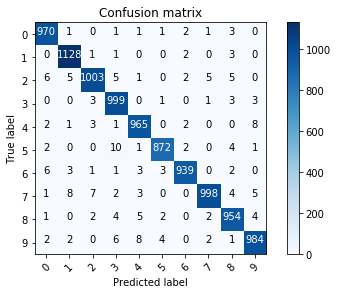

In [17]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))


# Complicated models with Dropout to avoid overfitting


**Dropout** is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass.

It reduces the number of parameters.

https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

In [18]:
# we define this model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, kernel_initializer='normal', activation = 'softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [19]:
# build the model
model = baseline_model()

# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

W0625 11:16:13.402725 4411364800 deprecation.py:506] From /Users/paoloandreini/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 6s - loss: 0.2494 - acc: 0.9245 - val_loss: 0.1062 - val_acc: 0.9661
Epoch 2/10
 - 5s - loss: 0.0932 - acc: 0.9708 - val_loss: 0.0801 - val_acc: 0.9740
Epoch 3/10
 - 5s - loss: 0.0664 - acc: 0.9791 - val_loss: 0.0678 - val_acc: 0.9770
Epoch 4/10
 - 5s - loss: 0.0482 - acc: 0.9847 - val_loss: 0.0617 - val_acc: 0.9800
Epoch 5/10
 - 5s - loss: 0.0381 - acc: 0.9874 - val_loss: 0.0809 - val_acc: 0.9753
Epoch 6/10
 - 5s - loss: 0.0325 - acc: 0.9894 - val_loss: 0.0565 - val_acc: 0.9826
Epoch 7/10
 - 5s - loss: 0.0257 - acc: 0.9913 - val_loss: 0.0617 - val_acc: 0.9820
Epoch 8/10
 - 5s - loss: 0.0253 - acc: 0.9919 - val_loss: 0.0636 - val_acc: 0.9809
Epoch 9/10
 - 5s - loss: 0.0230 - acc: 0.9923 - val_loss: 0.0635 - val_acc: 0.9827
Epoch 10/10
 - 5s - loss: 0.0179 - acc: 0.9941 - val_loss: 0.0621 - val_acc: 0.9826
Baseline Error: 1.74%


In [ ]:
model.summary()

In [ ]:
# Model evaluation
# evaluate model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
# Let's graphically see the output
# Predict the values from the validation dataset
y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))